In [1]:
import pandas as pd
import datetime
import requests
import plotly.graph_objects as go

def fetch_stock_data(ticker):
    api_key = 'YOUR_API_KEY'  # replace with your Alpha Vantage API key
    base_url = 'https://www.alphavantage.co/query?'
    function = 'TIME_SERIES_DAILY'
    
    # Define the parameters for the API request
    params = {
        'function': function,
        'symbol': ticker,
        'outputsize': 'full',  # get as much data as possible
        'apikey': api_key,
        'datatype': 'json'
    }
    
    response = requests.get(base_url, params=params)
    data = response.json()
    
    df = pd.DataFrame(data['Time Series (Daily)']).T
    df.index = pd.to_datetime(df.index)
    df = df.sort_index(ascending=True)
    df = df.astype(float)
    df = df.rename(columns={'4. close': 'Close'})
    return df

def compute_moving_averages(df):
    df['50_MA'] = df['Close'].rolling(window=50).mean()
    df['200_MA'] = df['Close'].rolling(window=200).mean()
    return df

def plot_moving_averages(df, ticker):
    fig = go.Figure()
    
    fig.add_trace(go.Scatter(x=df.index, y=df['Close'], mode='lines', name='Close'))
    fig.add_trace(go.Scatter(x=df.index, y=df['50_MA'], mode='lines', name='50 Day MA'))
    fig.add_trace(go.Scatter(x=df.index, y=df['200_MA'], mode='lines', name='200 Day MA'))
    
    fig.update_layout(title=f'{ticker} Closing Prices with 50-Day and 200-Day Moving Averages',
                      xaxis_title='Date',
                      yaxis_title='Price (USD)')
    
    fig.show()

ticker = input('Enter a stock ticker: ')
df = fetch_stock_data(ticker)
df = compute_moving_averages(df)
plot_moving_averages(df, ticker)


KeyError: 'Time Series (Daily)'

In [23]:
import nasdaqdatalink
import pandas as pd

df = nasdaqdatalink.get('BITFINEX/BTCUSD')
df = df.reset_index().rename(columns={'Last': 'Close'})#.reset_index() #[['Date', 'Last']]
#df.to_csv(os.getcwd()+ '\\data\\BITFINEX-BTCUSD.csv', index=False)

In [17]:
import os


df = pd.read_csv(os.getcwd()+'//data//BTC-USD.csv')
df 

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...,...
3178,2023-05-31,27700.529297,27831.677734,26866.453125,27219.658203,27219.658203,15656371534
3179,2023-06-01,27218.412109,27346.105469,26671.720703,26819.972656,26819.972656,14678970415
3180,2023-06-02,26824.556641,27303.861328,26574.644531,27249.589844,27249.589844,14837415000
3181,2023-06-03,27252.324219,27317.052734,26958.003906,27075.128906,27075.128906,8385597470


In [7]:
def calculate_atr(df, period):
    df['H-L'] = abs(df['High']-df['Low'])
    df['H-PC'] = abs(df['High']-df['Close'].shift(1))
    df['L-PC'] = abs(df['Low']-df['Close'].shift(1))
    df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)
    df['ATR'] = df['TR'].rolling(window=period).mean()
    df.drop(['H-L', 'H-PC', 'L-PC'], axis=1, inplace=True)
    return df

def calculate_supertrend(df, period, multiplier):
    df = calculate_atr(df, period)
    hl2 = (df['High'] + df['Low']) / 2
    df['upper_band'] = hl2 + multiplier * df['ATR']
    df['lower_band'] = hl2 - multiplier * df['ATR']
    df['in_uptrend'] = True

    for current in range(1, len(df.index)):
        previous = current - 1
        
        if df['Close'][current] > df['upper_band'][previous]:
            df['in_uptrend'][current] = True
        elif df['Close'][current] < df['lower_band'][previous]:
            df['in_uptrend'][current] = False
        else:
            df['in_uptrend'][current] = df['in_uptrend'][previous]
            
            if df['in_uptrend'][current] and df['lower_band'][current] < df['lower_band'][previous]:
                df['lower_band'][current] = df['lower_band'][previous]
                
            if not df['in_uptrend'][current] and df['upper_band'][current] > df['upper_band'][previous]:
                df['upper_band'][current] = df['upper_band'][previous]
    
    df['supertrend'] = df['upper_band'].where(~df['in_uptrend'], df['lower_band'])
    
    return df


# Function to calculate RSI
def calculate_rsi(df, periods=14, ema=True):
    delta = df["Close"].diff()

    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    if ema:
        gain = up.ewm(com=(periods - 1), min_periods=periods).mean()
        loss = down.abs().ewm(com=(periods - 1), min_periods=periods).mean()
    else:
        gain = up.rolling(window=periods).mean()
        loss = down.abs().rolling(window=periods).mean()

    RS = gain / loss
    return 100 - (100 / (1 + RS))

# Compute the 50-day and 200-day moving averages
df['50_MA'] = df['Close'].rolling(window=50).mean()
df['200_MA'] = df['Close'].rolling(window=200).mean()

# Calculate supertrend
df_supertrend = calculate_supertrend(df.copy(), period=7, multiplier=3)

# Calculate RSI
df_supertrend['RSI'] = calculate_rsi(df_supertrend)

df_supertrend.tail()


<ipython-input-7-71c42986da7d>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['in_uptrend'][current] = df['in_uptrend'][previous]
<ipython-input-7-71c42986da7d>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lower_band'][current] = df['lower_band'][previous]
<ipython-input-7-71c42986da7d>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['in_uptrend'][current] = False
<ipython-input-7-71c42986da7d>:31: SettingWithCopyWa

,Date,Open,High,Low,Close,Adj Close,Volume,50_MA,200_MA,TR,ATR,upper_band,lower_band,in_uptrend,supertrend,RSI
3178,2023-05-31,27700.529297,27831.677734,26866.453125,27219.658203,27219.658203,15656371534,28106.404688,22999.675181,965.224609,745.961496,29586.949917,25624.571289,True,25624.571289,48.102715
3179,2023-06-01,27218.412109,27346.105469,26671.720703,26819.972656,26819.972656,14678970415,28040.023086,23052.008218,674.384766,742.169922,29235.422852,25624.571289,True,25624.571289,44.475607
3180,2023-06-02,26824.556641,27303.861328,26574.644531,27249.589844,27249.589844,14837415000,27977.033555,23105.165171,729.216797,764.526507,29232.832451,25624.571289,True,25624.571289,48.932983
3181,2023-06-03,27252.324219,27317.052734,26958.003906,27075.128906,27075.128906,8385597470,27908.822148,23156.117749,359.048828,777.570313,29470.239258,25624.571289,True,25624.571289,47.273346
3182,2023-06-04,27065.878906,27273.507813,26971.458984,27201.251953,27201.251953,8778725376,27846.477266,23208.776812,302.048829,622.049107,28988.630721,25624.571289,True,25624.571289,48.629796


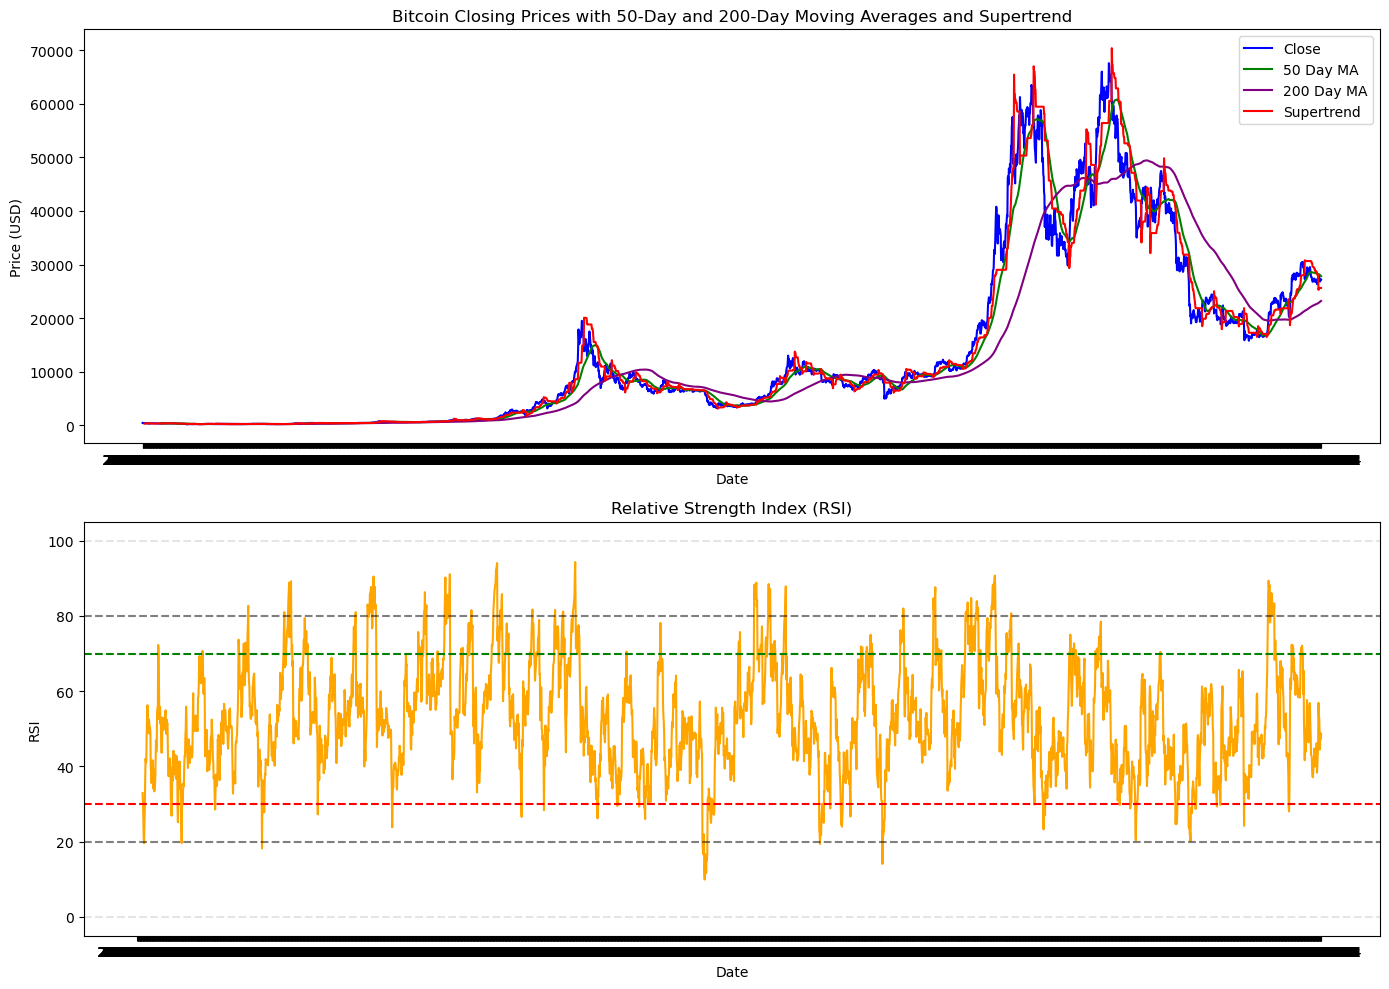

In [8]:
from matplotlib import pyplot as plt


fig, ax = plt.subplots(2, figsize=(14, 10))

# Plot the closing price, moving averages, and supertrend
ax[0].plot(df_supertrend['Date'], df_supertrend['Close'], label='Close', color='blue')
ax[0].plot(df_supertrend['Date'], df_supertrend['50_MA'], label='50 Day MA', color='green')
ax[0].plot(df_supertrend['Date'], df_supertrend['200_MA'], label='200 Day MA', color='purple')
ax[0].plot(df_supertrend['Date'], df_supertrend['supertrend'], label='Supertrend', color='red')
ax[0].set_title('Bitcoin Closing Prices with 50-Day and 200-Day Moving Averages and Supertrend')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Price (USD)')
ax[0].legend()

# Plot the RSI
ax[1].plot(df_supertrend['Date'], df_supertrend['RSI'], label='RSI', color='orange')
ax[1].axhline(0, linestyle='--', alpha=0.1, color='black')
ax[1].axhline(20, linestyle='--', alpha=0.5, color='black')
ax[1].axhline(30, linestyle='--', color='red')
ax[1].axhline(70, linestyle='--', color='green')
ax[1].axhline(80, linestyle='--', alpha=0.5, color='black')
ax[1].axhline(100, linestyle='--', alpha=0.1, color='black')
ax[1].set_title('Relative Strength Index (RSI)')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('RSI')

plt.tight_layout()
plt.show()
